In [1]:
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn import naive_bayes #import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score,balanced_accuracy_score,average_precision_score, classification_report

from sklearn.utils import shuffle
from collections import Counter

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
cfpb_df = pd.read_csv('../../data/CFPB with Duplicate Marked.csv')
print(cfpb_df.columns)
print(cfpb_df.shape)
cfpb_df = cfpb_df.drop_duplicates(subset='dupi_id')
print(cfpb_df.shape)

C:\Users\JYM\AppData\Local\Temp/ipykernel_25556/1144886652.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  cfpb_df = pd.read_csv('../../data/CFPB with Duplicate Marked.csv')


Index(['Unnamed: 0', 'Date received', 'Product', 'Sub-product', 'Issue',
       'Sub-issue', 'Consumer complaint narrative', 'Company public response',
       'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID', 'narr_len',
       'days_to_today', 'dupi_id', 'dupi_len'],
      dtype='object')
(1300361, 23)
(1106587, 23)


In [4]:
# Calculate y based on 'product' column
cfpb_df['debt_collection'] = (cfpb_df['Product'] == 'Debt collection').astype(int)

In [5]:
# split dataset train, dev, test
train_df, dev_df, test_df = np.split(cfpb_df[['Consumer complaint narrative','debt_collection']].sample(len(cfpb_df), random_state = 42), 
                                     [int(len(cfpb_df)*0.75), int(len(cfpb_df)*0.9)])

In [6]:
# Load the trained vectorizer
with open('tfidf_vectorizer_999.pkl', 'rb') as f:
    loaded_vectorizer = pickle.load(f)
len(loaded_vectorizer.get_feature_names_out())

16678

In [7]:
%%time
# Vectorize the text data with pre-tuned vectorizer
X_train = loaded_vectorizer.transform(train_df['Consumer complaint narrative'])
y_train = train_df['debt_collection']

X_dev = loaded_vectorizer.transform(dev_df['Consumer complaint narrative'])
y_dev = dev_df['debt_collection']

X_test = loaded_vectorizer.transform(test_df['Consumer complaint narrative'])
y_test = test_df['debt_collection']

Wall time: 4min 52s


In [8]:
%%time
# Select top 10000 features, 5000 runs faster without significant loss (almost the same)
selector = SelectKBest(chi2, k=5000)
X_train = selector.fit_transform(X_train, y_train)
X_dev = selector.transform(X_dev)
X_test = selector.transform(X_test)

Wall time: 358 ms


In [9]:
%%time
# some balancing
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# oversample = RandomOverSampler(sampling_strategy='minority')
# X_train_res, y_train_res = oversample.fit_resample(X_train, y_train)

Wall time: 12min 23s


### Gaussian Naive Bayes

In [10]:
# Shuffle your data
X_train_res, y_train_res = shuffle(X_train_res, y_train_res)

# traning Gaussian Naive Bayes
gnb = naive_bayes.GaussianNB()

# The partial fit if you ran out of RAM
batch_size = 50000
n_batches = X_train_res.shape[0] // batch_size

# partial fitting
for i in tqdm(range(n_batches)):
    start = i * batch_size
    end = (i + 1) * batch_size
    batch_X = X_train_res[start:end]
    batch_y = y_train_res[start:end]
    if i == 0:
        gnb.partial_fit(batch_X.A, batch_y, classes=np.unique(y_train_res)) 
        # The `.A` here converts the sparse matrix to a dense matrix.
        # This is necessary because GaussianNB doesn't support sparse matrices.
        # We also specify the classes parameter in the first call to partial_fit.
    else:
        gnb.partial_fit(batch_X.A, batch_y)

# # if you have enough RAM resources, just go big! For 17k features you need about 60+ GB of RAM
# gnb.fit(X_train_res,y_train_res)

100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [01:37<00:00,  3.62s/it]


In [11]:
# get the results
# again, if you have 117 GB of memorymyou can run this.
# y_pred = gnb.predict(X_train_res.toarray())
# y_pred_proba = gnb.predict_proba(X_train_res.toarray())

# Define batch size and number of batches
batch_size = 100
n_batches = X_train_res.shape[0] // batch_size

# Initialize lists to hold batch predictions
y_pred = []
y_pred_proba = []

# Iterate over each batch
for i in tqdm(range(n_batches)):
    start = i * batch_size
    end = (i + 1) * batch_size
    batch_X = X_train_res[start:end]

    # Predict on the batch and append to list
    batch_pred = gnb.predict(batch_X.A)
    batch_pred_proba = gnb.predict_proba(batch_X.A)

    y_pred.extend(batch_pred)
    y_pred_proba.extend(batch_pred_proba)

# Handling the remaining data
if X_train_res.shape[0] % batch_size != 0:
    start = n_batches * batch_size
    batch_X = X_train_res[start:]

    batch_pred = gnb.predict(batch_X.A)
    batch_pred_proba = gnb.predict_proba(batch_X.A)

    y_pred.extend(batch_pred)
    y_pred_proba.extend(batch_pred_proba)

# Convert lists to arrays for further use
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)


print("Train")
print("accuracy_score",accuracy_score(y_train_res, y_pred))
print("balanced_accuracy_score",balanced_accuracy_score(y_train_res, y_pred))
print("average_precision_score",average_precision_score(y_train_res, y_pred))
print(classification_report(y_train_res, y_pred))

100%|████████████████████████████████████████████████████████████████████████████| 13677/13677 [03:54<00:00, 58.41it/s]


Train
accuracy_score 0.7570402918619359
balanced_accuracy_score 0.7570402918619359
average_precision_score 0.6788296637306013
              precision    recall  f1-score   support

           0       0.87      0.60      0.71    683885
           1       0.70      0.91      0.79    683885

    accuracy                           0.76   1367770
   macro avg       0.79      0.76      0.75   1367770
weighted avg       0.79      0.76      0.75   1367770



Dev
accuracy_score 0.6503903896667229
balanced_accuracy_score 0.7414368844172521
average_precision_score 0.304203557556587
              precision    recall  f1-score   support

           0       0.96      0.60      0.74    136701
           1       0.32      0.88      0.47     29287

    accuracy                           0.65    165988
   macro avg       0.64      0.74      0.60    165988
weighted avg       0.85      0.65      0.69    165988

Prediction [(0, 85574), (1, 80414)]
Ground Truth [(0, 136701), (1, 29287)]
Wall time: 26.6 s


<AxesSubplot:ylabel='Frequency'>

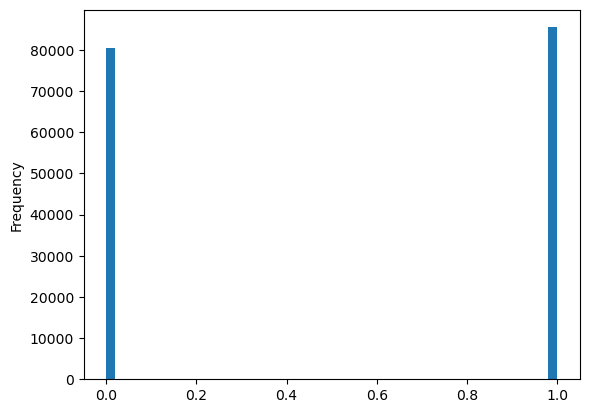

In [12]:
%%time
# development validation
y_pred = gnb.predict(X_dev.toarray())
y_pred_proba = gnb.predict_proba(X_dev.toarray())


# # Initialize lists to hold batch predictions
# y_pred = []
# y_pred_proba = []

# # Iterate over each batch
# for i in tqdm(range(n_batches)):
#     start = i * batch_size
#     end = (i + 1) * batch_size
#     batch_X = X_train_res[start:end]

#     # Predict on the batch and append to list
#     batch_pred = gnb.predict(batch_X.A)
#     batch_pred_proba = gnb.predict_proba(batch_X.A)

#     y_pred.extend(batch_pred)
#     y_pred_proba.extend(batch_pred_proba)

# # Convert lists to arrays for further use
# y_pred = np.array(y_pred)
# y_pred_proba = np.array(y_pred_proba)

print("Dev")
print("accuracy_score",accuracy_score(y_dev, y_pred))
print("balanced_accuracy_score",balanced_accuracy_score(y_dev, y_pred))
print("average_precision_score",average_precision_score(y_dev, y_pred))
print(classification_report(y_dev, y_pred))

c = Counter(y_pred)
print("Prediction", c.most_common(2))
c = Counter(y_dev)
print("Ground Truth",c.most_common(2))

prediction = pd.DataFrame(y_pred_proba)
prediction['result'] = y_pred
prediction[0].plot.hist(bins=50)

### Gaussian Naive Bayes - samll batch size

In [13]:
# Shuffle your data
X_train_res, y_train_res = shuffle(X_train_res, y_train_res)

# traning Gaussian Naive Bayes
gnb = naive_bayes.GaussianNB()

# The partial fit if you ran out of RAM
batch_size = 500
n_batches = X_train_res.shape[0] // batch_size

# partial fitting
for i in tqdm(range(n_batches)):
    start = i * batch_size
    end = (i + 1) * batch_size
    batch_X = X_train_res[start:end]
    batch_y = y_train_res[start:end]
    if i == 0:
        gnb.partial_fit(batch_X.A, batch_y, classes=np.unique(y_train_res)) 
        # The `.A` here converts the sparse matrix to a dense matrix.
        # This is necessary because GaussianNB doesn't support sparse matrices.
        # We also specify the classes parameter in the first call to partial_fit.
    else:
        gnb.partial_fit(batch_X.A, batch_y)

# # if you have enough RAM resources, just go big! For 17k features you need about 60+ GB of RAM
# gnb.fit(X_train_res,y_train_res)

100%|██████████████████████████████████████████████████████████████████████████████| 2735/2735 [01:19<00:00, 34.58it/s]


In [14]:
# get the results
# again, if you have 117 GB of memorymyou can run this.
# y_pred = gnb.predict(X_train_res.toarray())
# y_pred_proba = gnb.predict_proba(X_train_res.toarray())

# Define batch size and number of batches
batch_size = 100
n_batches = X_train_res.shape[0] // batch_size

# Initialize lists to hold batch predictions
y_pred = []
y_pred_proba = []

# Iterate over each batch
for i in tqdm(range(n_batches)):
    start = i * batch_size
    end = (i + 1) * batch_size
    batch_X = X_train_res[start:end]

    # Predict on the batch and append to list
    batch_pred = gnb.predict(batch_X.A)
    batch_pred_proba = gnb.predict_proba(batch_X.A)

    y_pred.extend(batch_pred)
    y_pred_proba.extend(batch_pred_proba)

# Handling the remaining data
if X_train_res.shape[0] % batch_size != 0:
    start = n_batches * batch_size
    batch_X = X_train_res[start:]

    batch_pred = gnb.predict(batch_X.A)
    batch_pred_proba = gnb.predict_proba(batch_X.A)

    y_pred.extend(batch_pred)
    y_pred_proba.extend(batch_pred_proba)

# Convert lists to arrays for further use
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)


print("Train")
print("accuracy_score",accuracy_score(y_train_res, y_pred))
print("balanced_accuracy_score",balanced_accuracy_score(y_train_res, y_pred))
print("average_precision_score",average_precision_score(y_train_res, y_pred))
print(classification_report(y_train_res, y_pred))

100%|████████████████████████████████████████████████████████████████████████████| 13677/13677 [03:25<00:00, 66.50it/s]


Train
accuracy_score 0.7570461407985261
balanced_accuracy_score 0.7570461407985261
average_precision_score 0.6788152788275422
              precision    recall  f1-score   support

           0       0.87      0.60      0.71    683885
           1       0.70      0.91      0.79    683885

    accuracy                           0.76   1367770
   macro avg       0.79      0.76      0.75   1367770
weighted avg       0.79      0.76      0.75   1367770



Dev
accuracy_score 0.6501554329228619
balanced_accuracy_score 0.7414149705575686
average_precision_score 0.3041459436219035
              precision    recall  f1-score   support

           0       0.96      0.60      0.74    136701
           1       0.32      0.88      0.47     29287

    accuracy                           0.65    165988
   macro avg       0.64      0.74      0.60    165988
weighted avg       0.85      0.65      0.69    165988

Prediction [(0, 85517), (1, 80471)]
Ground Truth [(0, 136701), (1, 29287)]
Wall time: 26.7 s


<AxesSubplot:ylabel='Frequency'>

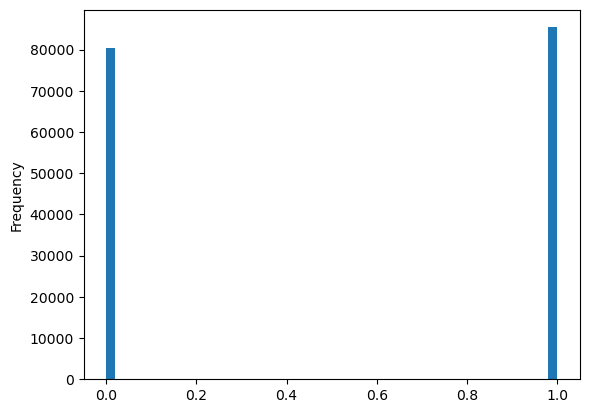

In [15]:
%%time
# development validation
y_pred = gnb.predict(X_dev.toarray())
y_pred_proba = gnb.predict_proba(X_dev.toarray())


# # Initialize lists to hold batch predictions
# y_pred = []
# y_pred_proba = []

# # Iterate over each batch
# for i in tqdm(range(n_batches)):
#     start = i * batch_size
#     end = (i + 1) * batch_size
#     batch_X = X_train_res[start:end]

#     # Predict on the batch and append to list
#     batch_pred = gnb.predict(batch_X.A)
#     batch_pred_proba = gnb.predict_proba(batch_X.A)

#     y_pred.extend(batch_pred)
#     y_pred_proba.extend(batch_pred_proba)

# # Convert lists to arrays for further use
# y_pred = np.array(y_pred)
# y_pred_proba = np.array(y_pred_proba)

print("Dev")
print("accuracy_score",accuracy_score(y_dev, y_pred))
print("balanced_accuracy_score",balanced_accuracy_score(y_dev, y_pred))
print("average_precision_score",average_precision_score(y_dev, y_pred))
print(classification_report(y_dev, y_pred))

c = Counter(y_pred)
print("Prediction", c.most_common(2))
c = Counter(y_dev)
print("Ground Truth",c.most_common(2))

prediction = pd.DataFrame(y_pred_proba)
prediction['result'] = y_pred
prediction[0].plot.hist(bins=50)

### Multinomial Naive Bayes

In [16]:
# Shuffle your data
X_train_res, y_train_res = shuffle(X_train_res, y_train_res)

# traning Gaussian Naive Bayes
mnb = naive_bayes.MultinomialNB()

# The partial fit if you ran out of RAM
batch_size = 50000
n_batches = X_train_res.shape[0] // batch_size

# partial fitting
for i in tqdm(range(n_batches)):
    start = i * batch_size
    end = (i + 1) * batch_size
    batch_X = X_train_res[start:end]
    batch_y = y_train_res[start:end]
    if i == 0:
        mnb.partial_fit(batch_X.A, batch_y, classes=np.unique(y_train_res)) 
        # The `.A` here converts the sparse matrix to a dense matrix.
        # This is necessary because GaussianNB doesn't support sparse matrices.
        # We also specify the classes parameter in the first call to partial_fit.
    else:
        mnb.partial_fit(batch_X.A, batch_y)

# # if you have enough RAM resources, just go big! For 17k features you need about 60+ GB of RAM
# mnb.fit(X_train_res,y_train_res)

100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:31<00:00,  1.16s/it]


In [17]:
# get the results
# y_pred = mnb.predict(X_train_res.toarray())
# y_pred_proba = mnb.predict_proba(X_train_res.toarray())

# Define batch size and number of batches
batch_size = 100
n_batches = X_train_res.shape[0] // batch_size

# Initialize lists to hold batch predictions
y_pred = []
y_pred_proba = []

# Iterate over each batch
for i in tqdm(range(n_batches)):
    start = i * batch_size
    end = (i + 1) * batch_size
    batch_X = X_train_res[start:end]

    # Predict on the batch and append to list
    batch_pred = mnb.predict(batch_X.A)
    batch_pred_proba = mnb.predict_proba(batch_X.A)

    y_pred.extend(batch_pred)
    y_pred_proba.extend(batch_pred_proba)

# Handling the remaining data
if X_train_res.shape[0] % batch_size != 0:
    start = n_batches * batch_size
    batch_X = X_train_res[start:]

    batch_pred = mnb.predict(batch_X.A)
    batch_pred_proba = mnb.predict_proba(batch_X.A)

    y_pred.extend(batch_pred)
    y_pred_proba.extend(batch_pred_proba)

# Convert lists to arrays for further use
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

print("Train")
print("accuracy_score",accuracy_score(y_train_res, y_pred))
print("balanced_accuracy_score",balanced_accuracy_score(y_train_res, y_pred))
print("average_precision_score",average_precision_score(y_train_res, y_pred))
print(classification_report(y_train_res, y_pred))

100%|███████████████████████████████████████████████████████████████████████████| 13677/13677 [00:58<00:00, 235.10it/s]


Train
accuracy_score 0.8291679156583344
balanced_accuracy_score 0.8291679156583344
average_precision_score 0.7801953676297642
              precision    recall  f1-score   support

           0       0.81      0.86      0.83    683885
           1       0.85      0.80      0.82    683885

    accuracy                           0.83   1367770
   macro avg       0.83      0.83      0.83   1367770
weighted avg       0.83      0.83      0.83   1367770



Dev
accuracy_score 0.8493445309299468
balanced_accuracy_score 0.8267438967846361
average_precision_score 0.4728902453649393
              precision    recall  f1-score   support

           0       0.95      0.86      0.90    136701
           1       0.55      0.79      0.65     29287

    accuracy                           0.85    165988
   macro avg       0.75      0.83      0.78    165988
weighted avg       0.88      0.85      0.86    165988

Prediction [(0, 123888), (1, 42100)]
Ground Truth [(0, 136701), (1, 29287)]
Wall time: 6.59 s


<AxesSubplot:ylabel='Frequency'>

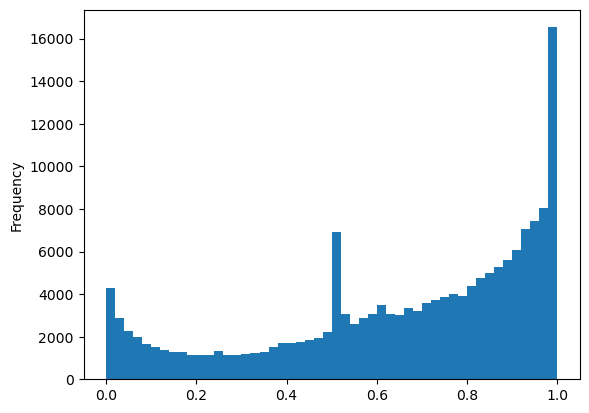

In [18]:
%%time
# development validation
y_pred = mnb.predict(X_dev.toarray())
y_pred_proba = mnb.predict_proba(X_dev.toarray())

print("Dev")
print("accuracy_score",accuracy_score(y_dev, y_pred))
print("balanced_accuracy_score",balanced_accuracy_score(y_dev, y_pred))
print("average_precision_score",average_precision_score(y_dev, y_pred))
print(classification_report(y_dev, y_pred))

c = Counter(y_pred)
print("Prediction", c.most_common(2))
c = Counter(y_dev)
print("Ground Truth",c.most_common(2))

prediction = pd.DataFrame(y_pred_proba)
prediction['result'] = y_pred
prediction[0].plot.hist(bins=50)

### Multinomial Naive Bayes  smaller batch size

In [19]:
# Shuffle your data
X_train_res, y_train_res = shuffle(X_train_res, y_train_res)

# traning Gaussian Naive Bayes
mnb = naive_bayes.MultinomialNB()

# The partial fit if you ran out of RAM
batch_size = 500
n_batches = X_train_res.shape[0] // batch_size

# partial fitting
for i in tqdm(range(n_batches)):
    start = i * batch_size
    end = (i + 1) * batch_size
    batch_X = X_train_res[start:end]
    batch_y = y_train_res[start:end]
    if i == 0:
        mnb.partial_fit(batch_X.A, batch_y, classes=np.unique(y_train_res)) 
        # The `.A` here converts the sparse matrix to a dense matrix.
        # This is necessary because GaussianNB doesn't support sparse matrices.
        # We also specify the classes parameter in the first call to partial_fit.
    else:
        mnb.partial_fit(batch_X.A, batch_y)

# # if you have enough RAM resources, just go big! For 17k features you need about 60+ GB of RAM
# mnb.fit(X_train_res,y_train_res)

100%|██████████████████████████████████████████████████████████████████████████████| 2735/2735 [00:32<00:00, 83.60it/s]


In [20]:
# get the results
# y_pred = mnb.predict(X_train_res.toarray())
# y_pred_proba = mnb.predict_proba(X_train_res.toarray())

# Define batch size and number of batches
batch_size = 100
n_batches = X_train_res.shape[0] // batch_size

# Initialize lists to hold batch predictions
y_pred = []
y_pred_proba = []

# Iterate over each batch
for i in tqdm(range(n_batches)):
    start = i * batch_size
    end = (i + 1) * batch_size
    batch_X = X_train_res[start:end]

    # Predict on the batch and append to list
    batch_pred = mnb.predict(batch_X.A)
    batch_pred_proba = mnb.predict_proba(batch_X.A)

    y_pred.extend(batch_pred)
    y_pred_proba.extend(batch_pred_proba)

# Handling the remaining data
if X_train_res.shape[0] % batch_size != 0:
    start = n_batches * batch_size
    batch_X = X_train_res[start:]

    batch_pred = mnb.predict(batch_X.A)
    batch_pred_proba = mnb.predict_proba(batch_X.A)

    y_pred.extend(batch_pred)
    y_pred_proba.extend(batch_pred_proba)

# Convert lists to arrays for further use
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

print("Train")
print("accuracy_score",accuracy_score(y_train_res, y_pred))
print("balanced_accuracy_score",balanced_accuracy_score(y_train_res, y_pred))
print("average_precision_score",average_precision_score(y_train_res, y_pred))
print(classification_report(y_train_res, y_pred))

100%|███████████████████████████████████████████████████████████████████████████| 13677/13677 [00:58<00:00, 232.88it/s]


Train
accuracy_score 0.8291576800193015
balanced_accuracy_score 0.8291576800193015
average_precision_score 0.7801826992019409
              precision    recall  f1-score   support

           0       0.81      0.86      0.83    683885
           1       0.85      0.80      0.82    683885

    accuracy                           0.83   1367770
   macro avg       0.83      0.83      0.83   1367770
weighted avg       0.83      0.83      0.83   1367770



Dev
accuracy_score 0.8492541629515387
balanced_accuracy_score 0.8266219585013779
average_precision_score 0.4726805359686305
              precision    recall  f1-score   support

           0       0.95      0.86      0.90    136701
           1       0.55      0.79      0.65     29287

    accuracy                           0.85    165988
   macro avg       0.75      0.83      0.78    165988
weighted avg       0.88      0.85      0.86    165988

Prediction [(0, 123883), (1, 42105)]
Ground Truth [(0, 136701), (1, 29287)]
Wall time: 6.54 s


<AxesSubplot:ylabel='Frequency'>

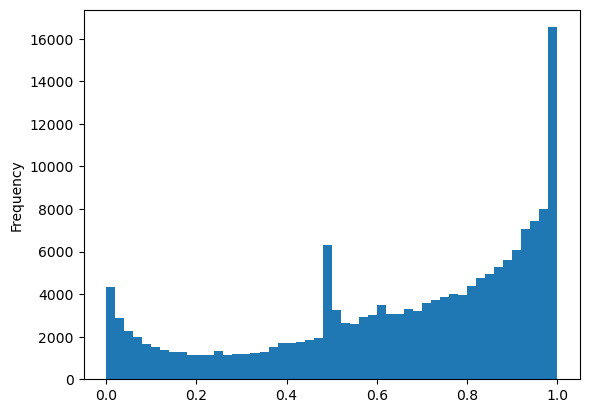

In [21]:
%%time
# development validation
y_pred = mnb.predict(X_dev.toarray())
y_pred_proba = mnb.predict_proba(X_dev.toarray())

print("Dev")
print("accuracy_score",accuracy_score(y_dev, y_pred))
print("balanced_accuracy_score",balanced_accuracy_score(y_dev, y_pred))
print("average_precision_score",average_precision_score(y_dev, y_pred))
print(classification_report(y_dev, y_pred))

c = Counter(y_pred)
print("Prediction", c.most_common(2))
c = Counter(y_dev)
print("Ground Truth",c.most_common(2))

prediction = pd.DataFrame(y_pred_proba)
prediction['result'] = y_pred
prediction[0].plot.hist(bins=50)